# Automatic Speech Recognition Hand-on & Advanced Kaldi Toolkit Courses
by Yuan-Fu Liao, National Taipei University of Technology
* yfliao@ntut.edu.tw
---

# Introduction to Speech Analysis and Feature Extraction

Singing in the MRI with Tyley Ross - Making the Voice Visible
* https://youtu.be/J3TwTb-T044

How Hearing Works - Process of Hearing Animation. Function & Parts of Human Ear. Sound Pathway
* https://youtu.be/T8lKKlnnC6M

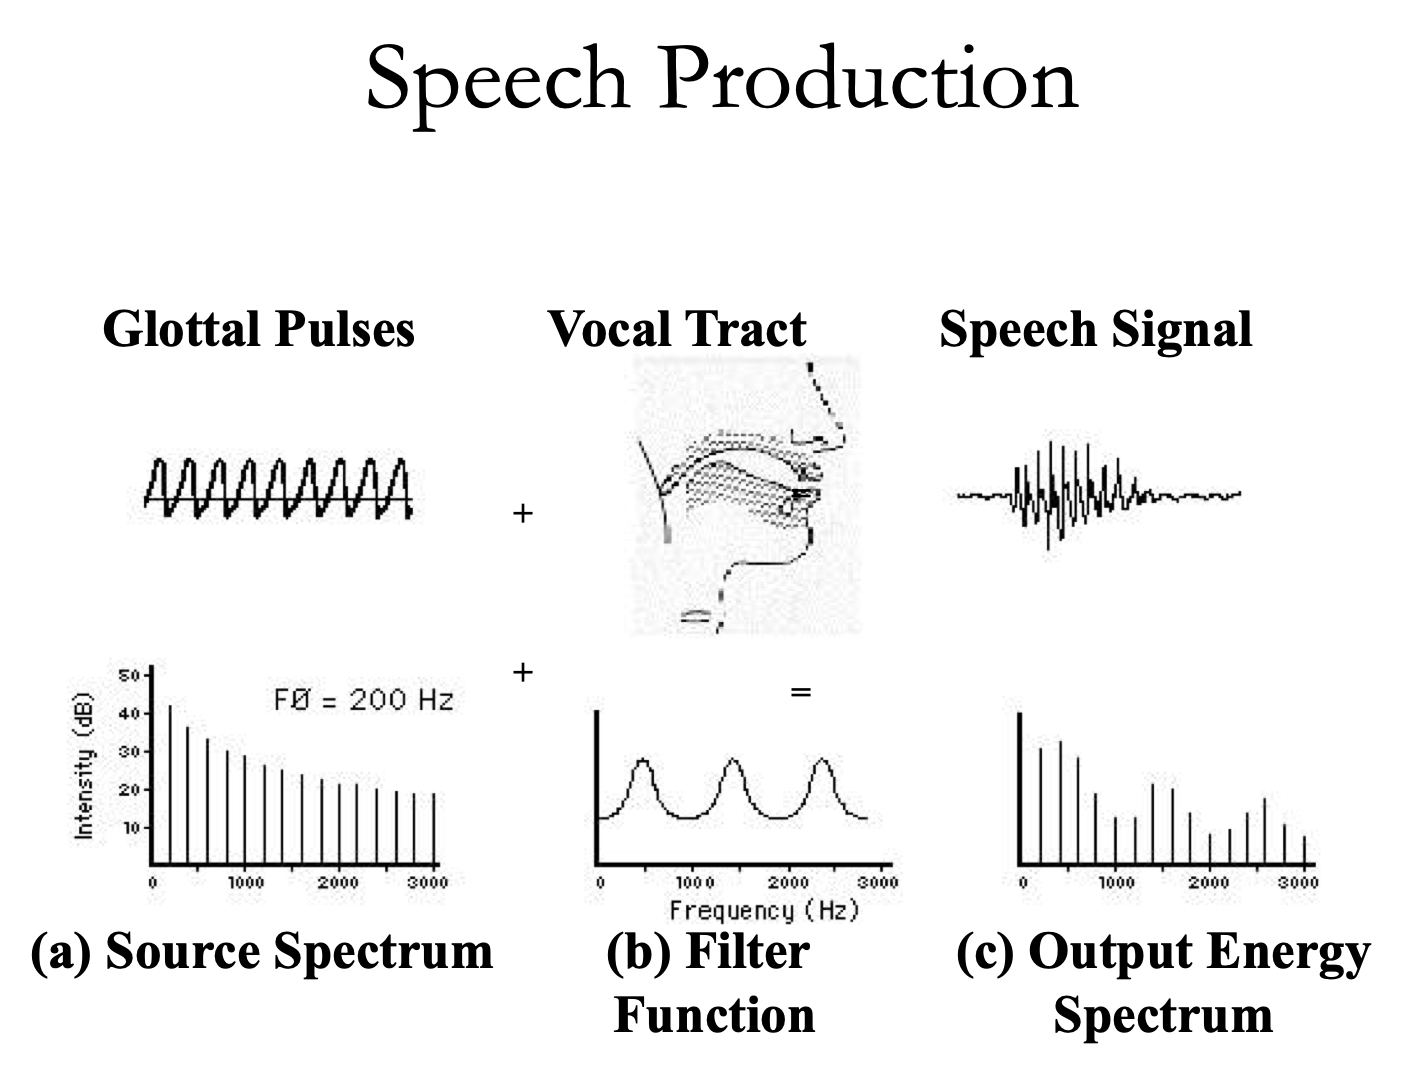

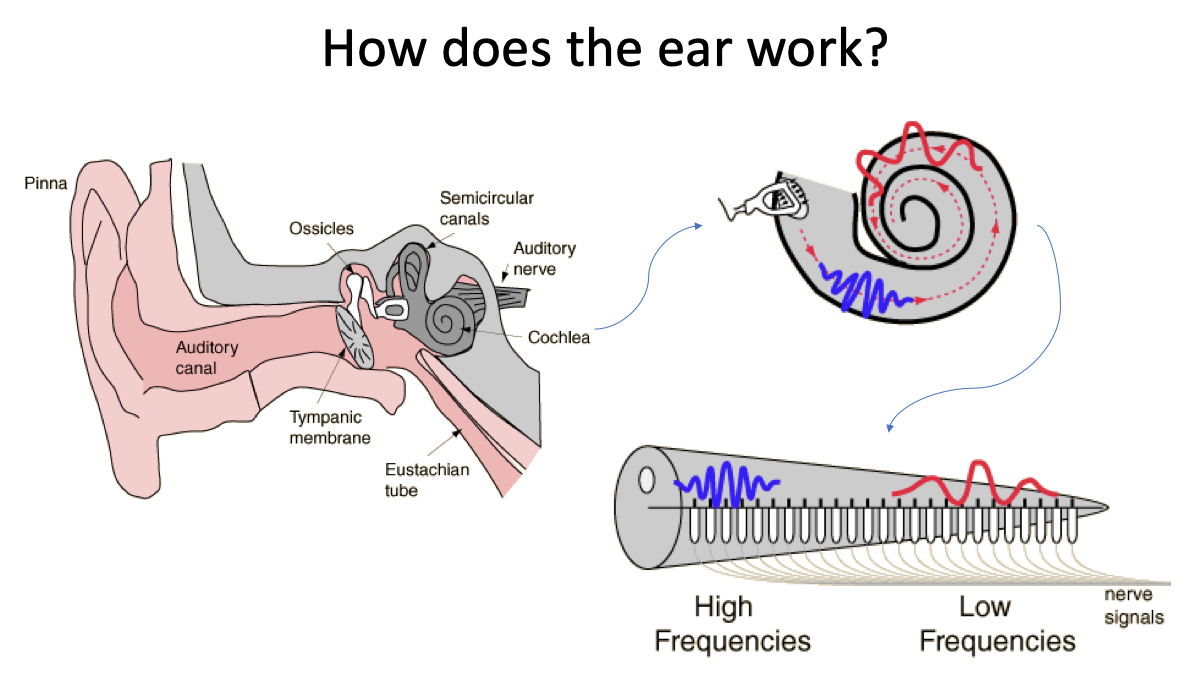

Speech Feature Extraaction

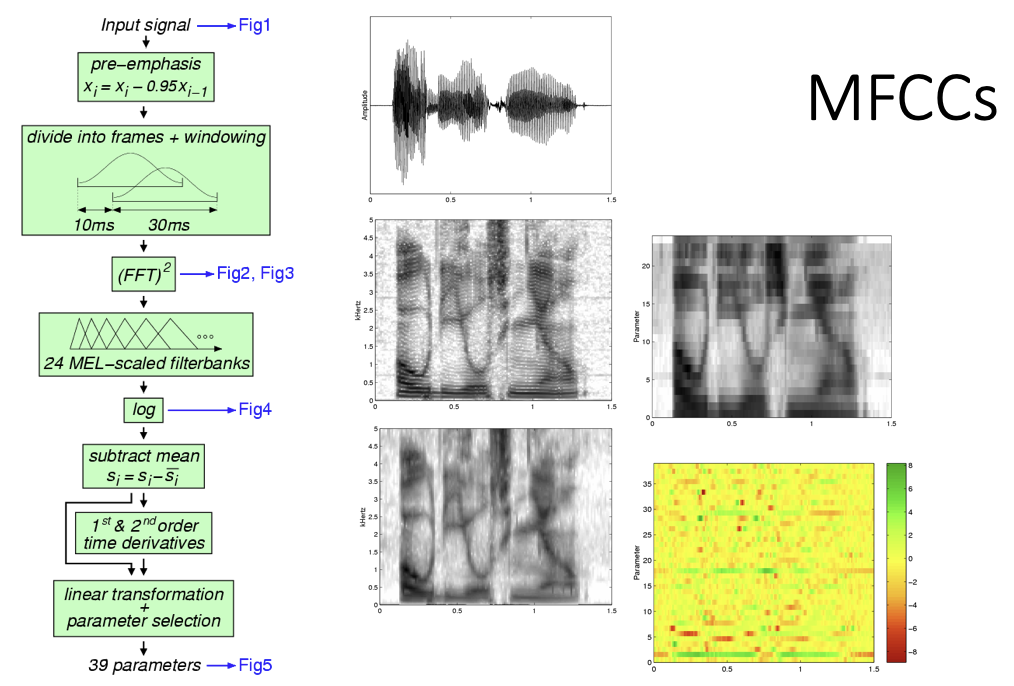

# Virtual Machine

## Hardware and Software

In [0]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic


In [0]:
import sys ; print(sys.version_info)

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [0]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [0]:
!cat /proc/cpuinfo | grep 'core id'

core id		: 0
core id		: 0


In [1]:
!nvidia-smi

Thu Nov 21 03:20:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!df

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        375674948 31440148 325081904   9% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6667596        0   6667596   0% /sys/fs/cgroup
/dev/sda1      382718764 41093792 341608588  11% /opt/bin
tmpfs            6667596       12   6667584   1% /var/colab
shm              6160384        4   6160380   1% /dev/shm
tmpfs            6667596        0   6667596   0% /proc/acpi
tmpfs            6667596        0   6667596   0% /proc/scsi
tmpfs            6667596        0   6667596   0% /sys/firmware


## Requirements

In [0]:
!sudo apt update
!sudo apt install libasound-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!sudo apt install python-pyaudio

In [0]:
!pip install pyaudio
!pip install ffmpeg-python
!pip install librosa
!pip install pydub
!pip install praat-parselmouth
!pip install sklearn

# Microphone

In [0]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);

function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

# Speech Analysis

## Import Packages

In [0]:
import os # to save/open files 
import sys
import io
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import ffmpeg
import wave
import pydub
from pydub import AudioSegment
from scipy.io.wavfile import read as wav_read
import matplotlib.pyplot as plt
import librosa
import librosa.display
import parselmouth
from sklearn import preprocessing

## Function Calls

### Read/Write Ausio Files

In [0]:
def write_wav(f, sr, x, normalized=False):
    # 開檔
    f = wave.open(f, "wb")

    # 配置聲道数、量化位数和取樣频率
    f.setnchannels(1)
    f.setsampwidth(2)
    f.setframerate(sr)

    # 轉換為二進制，再寫入檔案
    wave_data = x.astype(np.short)
    f.writeframes(wave_data.tostring())
    f.close()

### Draw Pictures

In [0]:
def get_audio():
		global hnum

		# call microphone
		display(HTML(AUDIO_HTML))
		data = eval_js("data")
		binary = b64decode(data.split(',')[1])
  
		process = (ffmpeg
	  		.input('pipe:0')
	  		.output('pipe:1', format='wav')
	  		.run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
		)
		output, err = process.communicate(input=binary)
  
		riff_chunk_size = len(output) - 8
		# Break up the chunk size into four bytes, held in b.
		q = riff_chunk_size
		b = []
		for i in range(4):
				q, r = divmod(q, 256)
				b.append(r)

		# Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
		riff = output[:4] + bytes(b) + output[8:]
		sr, audio = wav_read(io.BytesIO(riff))

		# save
		hnum += 1
		human_sound_file = "human-"+str(hnum)+".wav"
		print(human_sound_file)
		write_wav(human_sound_file, sr, audio)

		return human_sound_file

In [0]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

## Global Variables

In [0]:
hnum = 1

## Analysis
* Feature Extraction for Speech/Speaker/Langauge/Emotion Recognition, Speech Synthesis, Voice Conversion, and so on.

In [0]:
# Human Speak
human_sound_file = get_audio() 

In [0]:
# Speech Analysis: narrowband/wideband specgram, pitch
sr, audio = wav_read(human_sound_file)
print(sr, audio, audio.dtype, audio.shape)
audio = audio.astype(float)

### Waveform

In [0]:
plt.figure(figsize=(12, 8))
librosa.display.waveplot(audio, sr=sr)

### Spectogram

In [0]:
x = librosa.stft(audio, n_fft=2048, hop_length=480) # sampling rate=48000, frame_size=32 ms, frame_shift=10 ms
plt.figure(figsize=(12, 8))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x)), sr=sr, y_axis='linear', x_axis='time')

### Pitch Tracking

In [0]:
pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
plt.figure(figsize=(28, 8))
plt.subplot(1,2,1)
plt.imshow(pitches[:, :], aspect="auto", interpolation="nearest", origin="bottom")
plt.subplot(1,2,2)
plt.imshow(pitches[:100, :], aspect="auto", interpolation="nearest", origin="bottom")

### Resampling

In [0]:
plt.figure(figsize=(24, 8))

plt.subplot(1,2,1)
x = librosa.stft(audio, n_fft=2048, hop_length=480) # # sampling rate=16000, frame_size=32 ms, frame_shift=10 ms
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x)), sr=sr, y_axis='linear', x_axis='time')

# resampling
target_sr = 16000
audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
sr = target_sr

plt.subplot(1,2,2)
x = librosa.stft(audio, n_fft=2048, hop_length=480) # # sampling rate=16000, frame_size=32 ms, frame_shift=10 ms
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x)), sr=sr, y_axis='linear', x_axis='time')

### NarrowBand and WideBand Spectogram

In [0]:
plt.figure(figsize=(24, 8))

plt.subplot(1,2,1)
x = librosa.stft(audio, n_fft=2048, hop_length=80) # # sampling rate=16000, frame_size=32 ms, frame_shift=10 ms
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x)), sr=sr, y_axis='linear', x_axis='time')

plt.subplot(1,2,2)
x = librosa.stft(audio, n_fft=128, hop_length=80) # # sampling rate=16000, frame_size=32 ms, frame_shift=10 ms
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x)), sr=sr, y_axis='linear', x_axis='time')

### Pitch Contour Extraction

In [0]:
snd = parselmouth.Sound(human_sound_file)
snd.resample(new_frequency=16000)
pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)

plt.figure(figsize=(12, 8))
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram_0.03.pdf")

### Mel-Scaled Spectogram

In [0]:
plt.figure(figsize=(24, 8))

plt.subplot(1,2,1)
x = librosa.stft(audio, n_fft=2048, hop_length=80) # # sampling rate=16000, frame_size=32 ms, frame_shift=10 ms
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x)), sr=sr, y_axis='linear', x_axis='time')
# Put a descriptive title on the plot
plt.title('linear power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')


plt.subplot(1,2,2)
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(audio, sr=sr, n_mels=128)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

### MFCCs

In [0]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)
print(mfcc.shape)
print(mfcc)

# zero mean, unit variance
mfcc        = preprocessing.scale(mfcc,axis=1)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12.5, 12))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

# Time-Stretching and Pitch-Shifting 

## Introduction
* Useful for Data Augmentation

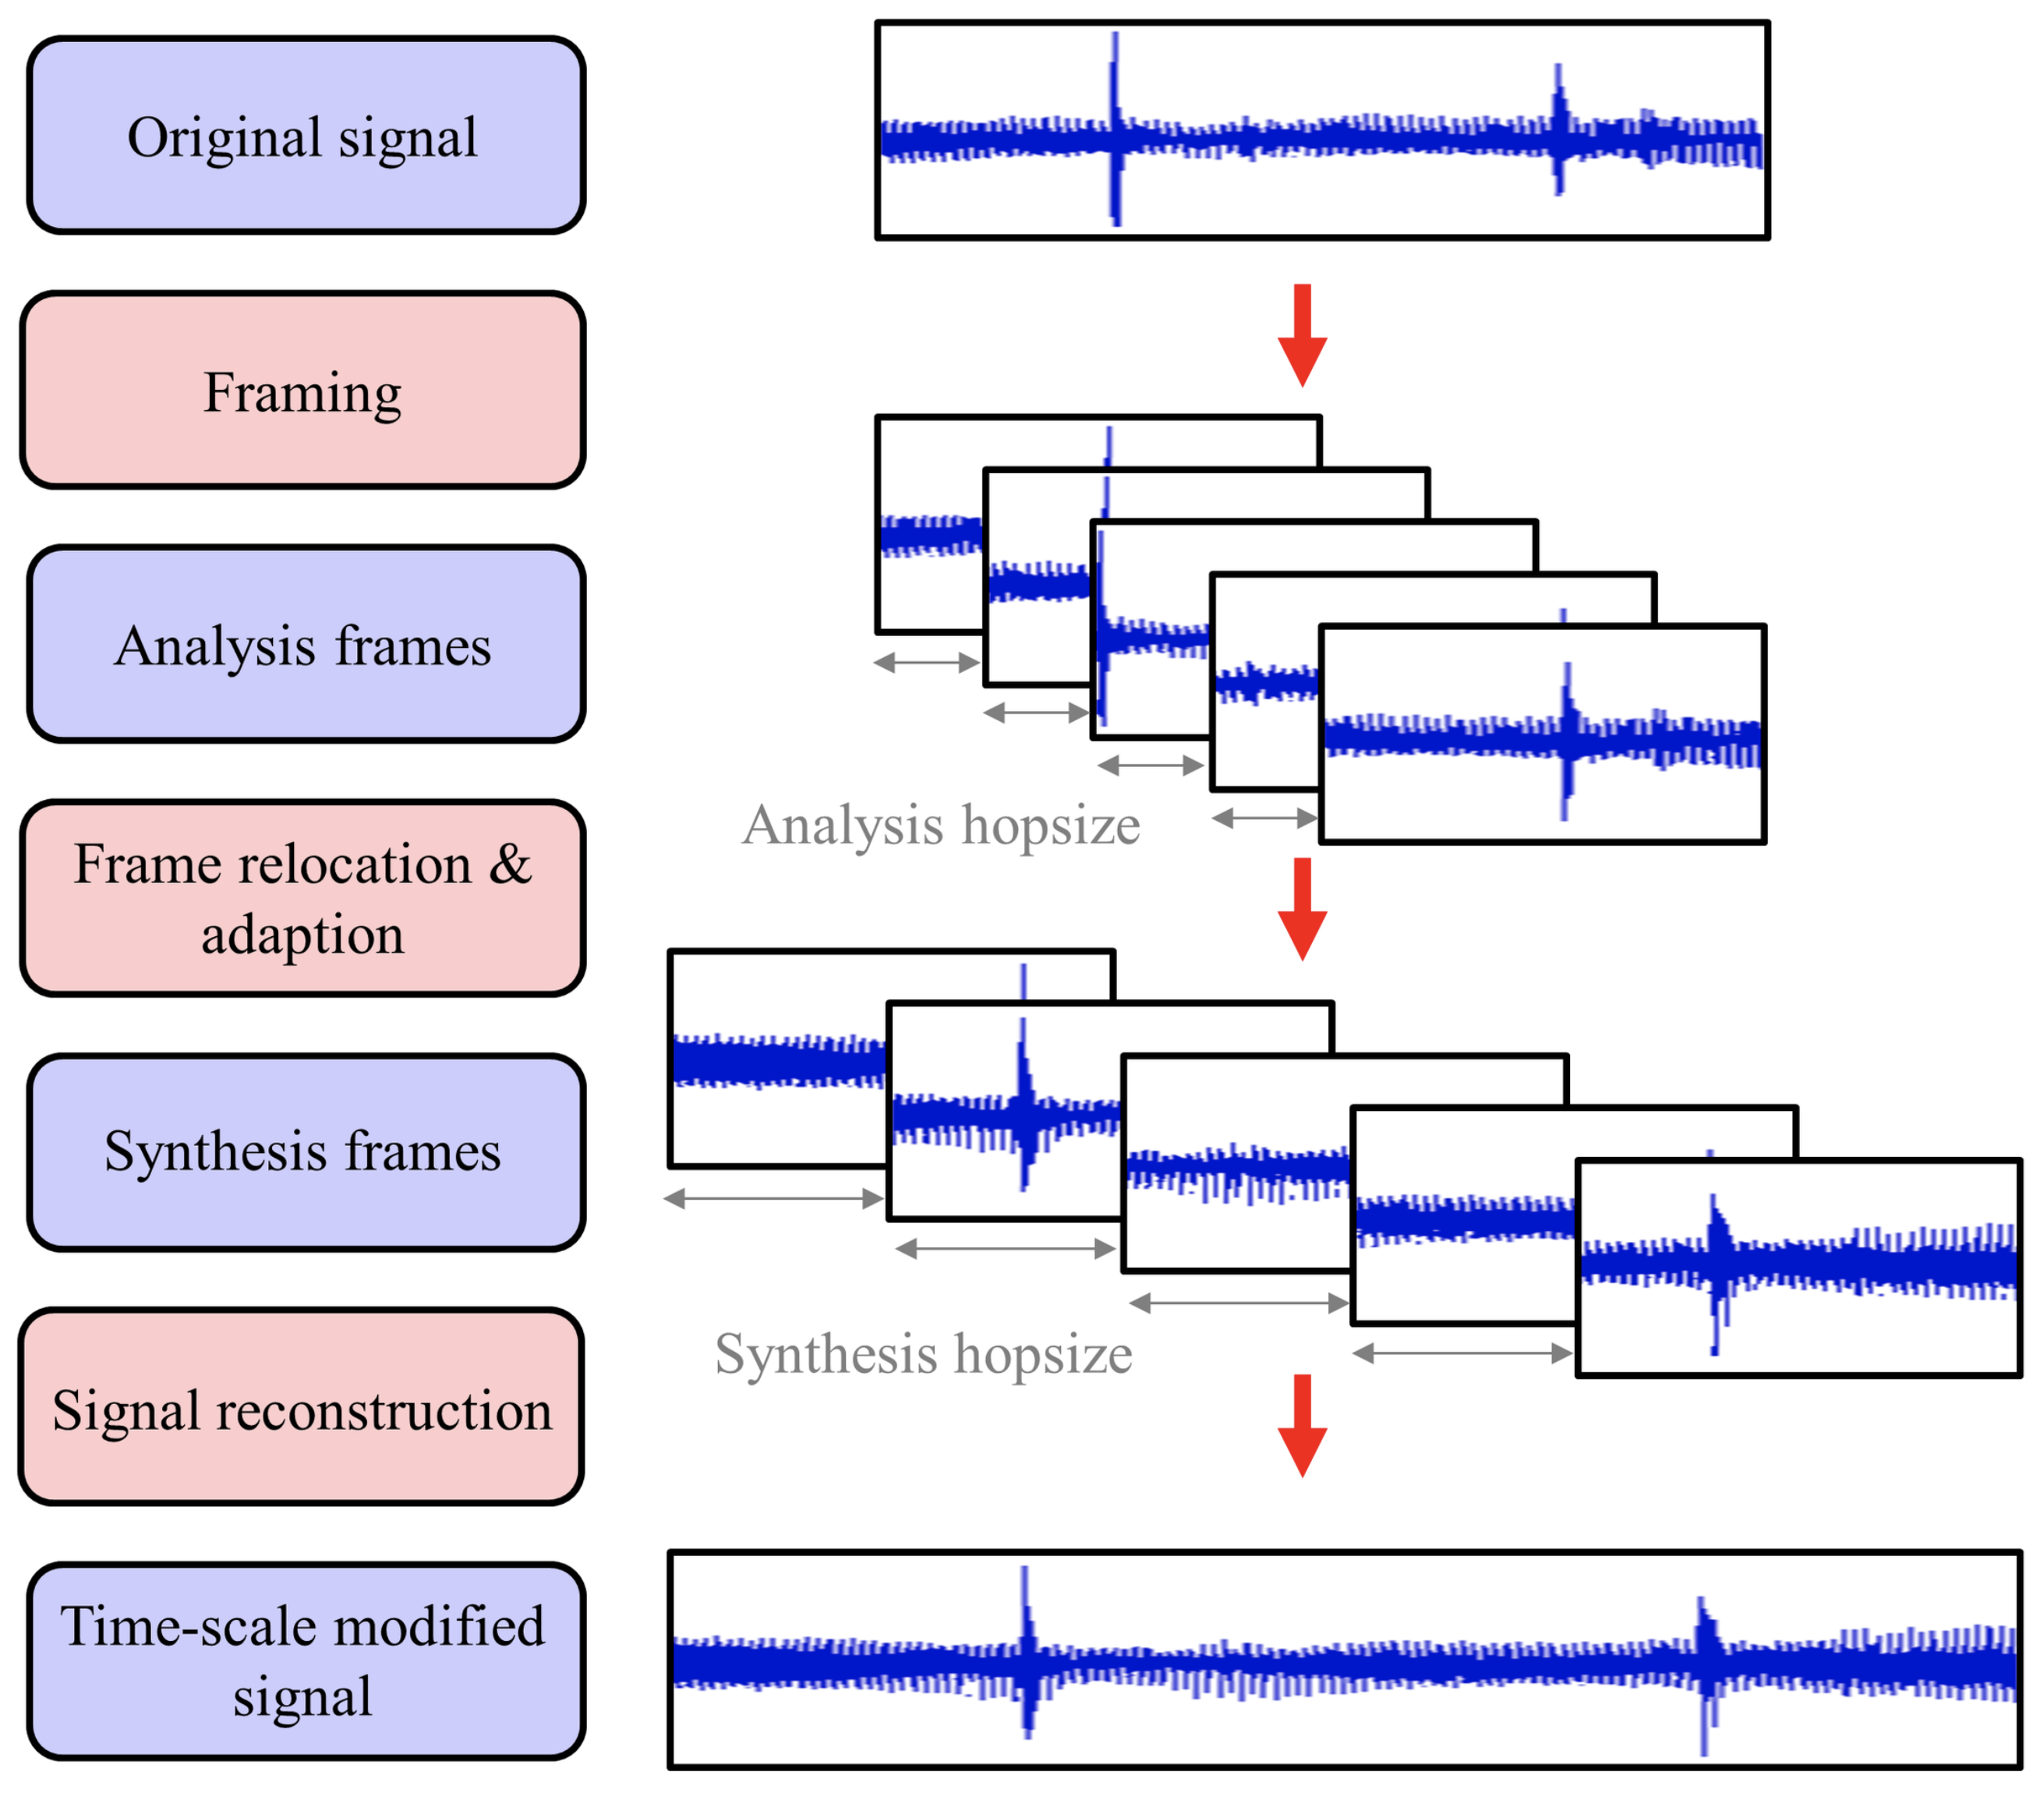

## Rubber Band
* An audio time-stretching and pitch-shifting library and utility program

In [0]:
!sudo apt install qttools5-dev qttools5-dev-tools libqt5svg5-dev ladspa-sdk git cmake libsndfile1-dev libsamplerate-ocaml-dev libjack-jackd2-dev libfftw3-dev libsamplerate0-dev vamp-plugin-sdk
!sudo apt install rubberband-cli
!sudo apt install rubberband-ladspa
!sudo apt install rubberband-vamp
!sudo apt install librubberband-dev

In [0]:
# Human Speak
human_sound_file = get_audio()

In [0]:
#  Usage: rubberband [options] <infile.wav> <outfile.wav>
#  -t<X>, --time <X>       Stretch to X times original duration, or
#  -T<X>, --tempo <X>      Change tempo by multiple X (same as --time 1/X), or
#  -T<X>, --tempo <X>:<Y>  Change tempo from X to Y (same as --time X/Y), or
#  -D<X>, --duration <X>   Stretch or squash to make output file X seconds long
#  -p<X>, --pitch <X>      Raise pitch by X semitones, or
#  -f<X>, --frequency <X>  Change frequency by multiple X

time = 1.5
pitch = 2.0

In [0]:
!rubberband -t $time -p $pitch $human_sound_file output.wav

In [0]:
plt.figure(figsize=(28, 8))

plt.subplot(1,2,1)
snd = parselmouth.Sound(human_sound_file)
pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)

draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])

plt.subplot(1,2,2)
snd = parselmouth.Sound('output.wav')
pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)

draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])


In [0]:
Audio(human_sound_file, autoplay=False)

In [0]:
Audio('output.wav', autoplay=False)